# Detecting Pneumonia by Using CNNs

## I. Overview

## II. Business Problem

## III. Data Understanding

## IV. Data Preparation

In [21]:
import os
import pandas as pd

import numpy as np
np.set_printoptions(precision=4, suppress=True)

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
from tensorflow import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import models
from tensorflow.keras import layers

from tensorflow.keras import regularizers

from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:
random.set_seed(24)

In [24]:
# File directory
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'
val_dir = 'chest_xray/val'

In [25]:
# Get all the train data (5216) in the directory, scale, and reshape
train_generator = ImageDataGenerator(rescale=1./255)\
                  .flow_from_directory(train_dir, target_size=(128,128), batch_size=5216)

# Get all the test data (624) in the directory, scale, and reshape
test_generator = ImageDataGenerator(rescale=1./255)\
                 .flow_from_directory(test_dir, target_size=(128,128), batch_size=624) 

# Get all the validation data (16) in the directory, scale, and reshape
val_generator = ImageDataGenerator(rescale=1./255)\
                .flow_from_directory(val_dir, target_size=(128,128), batch_size=16) 

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [26]:
# create the data sets
# next - retrieve the next item from iterator
X_train, train_labels = next(train_generator)
X_test, test_labels = next(test_generator)
X_val, val_labels = next(val_generator)

In [27]:
# Check the shape
print ("train_images shape: " + str(X_train.shape))
print ("train_labels shape: " + str(train_labels.shape))

print ("test_images shape: " + str(X_test.shape))
print ("test_labels shape: " + str(test_labels.shape))

print ("val_images shape: " + str(X_val.shape))
print ("val_labels shape: " + str(val_labels.shape))

train_images shape: (5216, 128, 128, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 128, 128, 3)
test_labels shape: (624, 2)
val_images shape: (16, 128, 128, 3)
val_labels shape: (16, 2)


In [28]:
y_train = np.reshape(train_labels[:,0], (5216,1))
y_test = np.reshape(test_labels[:,0], (624,1))
y_val = np.reshape(val_labels[:,0], (16,1))

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(5216, 1)
(624, 1)
(16, 1)


In [29]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [30]:
def model_evaluation(model):
    result_train = model.evaluate(X_train, y_train)
    print(f'Training Loss:{result_train[0]:.4}')
    print(f'Training Accuracy:{result_train[1]:.4}')
    
    result_val = model.evaluate(X_val, y_val)
    print(f'Val Loss:{result_val[0]:.4}')
    print(f'Val Accuracy:{result_val[1]:.4}')

### Note:
- Since the <u>*validation set*</u> contains much less data than the <u>*test set*</u>, I will use the <u>*test set*</u> as my validation during the model fit step
- <u>*validation set*</u> will be used as true holdout which only use at the end 

### Problem of small validation set
- If the validation set contains much less data than training set, the validation curves (accuracy and loss) will be spiky before convergence. In other words, more epochs and longer training time will be required

## V. Modeling

### MLP

In [ ]:
mlp = models.Sequential()
mlp.add(layers.Dense(100, activation='relu', input_shape=(49152,)))
mlp.add(layers.Dense(50, activation='relu'))
mlp.add(layers.Dense(25, activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
mlp.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [ ]:
mlp_history = mlp.fit(train_x, y_train,
                      epochs=50,
                      batch_size=25,
                      validation_data=(test_x, y_test))

In [ ]:
result_train = base_model.evaluate(train_x, y_train)
print(result_train)

result_test = base_model.evaluate(val_x, y_val)
print(result_test)

### CNN Baseline Model
- 3 block

In [11]:
base_model = models.Sequential()
base_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Flatten())
base_model.add(layers.Dense(128, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [12]:
base_history = base_model.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 43s 260ms/step - loss: 0.4430 - accuracy: 0.7968 - val_loss: 0.4689 - val_accuracy: 0.8013
Epoch 2/50
163/163 [==============================] - 41s 254ms/step - loss: 0.1252 - accuracy: 0.9530 - val_loss: 1.1855 - val_accuracy: 0.7276
Epoch 3/50
163/163 [==============================] - 41s 254ms/step - loss: 0.0680 - accuracy: 0.9765 - val_loss: 0.8361 - val_accuracy: 0.7596
Epoch 4/50
163/163 [==============================] - 42s 256ms/step - loss: 0.0622 - accuracy: 0.9807 - val_loss: 0.8057 - val_accuracy: 0.7772
Epoch 5/50
163/163 [==============================] - 42s 257ms/step - loss: 0.0582 - accuracy: 0.9804 - val_loss: 0.8775 - val_accuracy: 0.7724
Epoch 6/50
163/163 [==============================] - 42s 258ms/step - loss: 0.0506 - accuracy: 0.9828 - val_loss: 1.0743 - val_accuracy: 0.7420
Epoch 7/50
163/163 [==============================] - 42s 259ms/step - loss: 0.0376 - accuracy: 0.9871 - val_loss: 1.0228 - val_ac

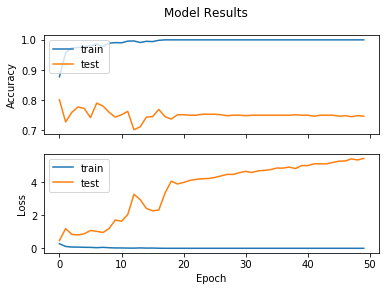

In [13]:
visualize_training_results(base_history)

In [14]:
base_model.save('base_model.h5')

In [15]:
base = load_model('base_model.h5')
model_evaluation(base)

163/163 [==============================] - 10s 62ms/step - loss: 1.8565e-06 - accuracy: 1.0000
Training Loss:1.857e-06
Training Accuracy:1.0
1/1 [==============================] - 0s 125ms/step - loss: 0.4588 - accuracy: 0.9375
Val Loss:0.4588
Val Accuracy:0.9375


>**Comment:** *Baseline Model*
- The CNN baseline model took about 40 minutes to run
- The train accuracy (1.0) is higher than val accuracy (0.9375) which indicates that the baseline model is overfit
- The accuracy plot shows that test accuracy reaches convergence after 20 epochs 
- The loss plot shows that test loss still increase after 20 epochs
- Early stopping can be used for iteration model tunning to prevent overfit and saving time

### Try some pred_prob

In [ ]:
base.predict_prob(X_val)

### Dropout 20
- Add (20%) dropout layers and earlystopping 

In [16]:
dropout_20 = models.Sequential()
dropout_20.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
dropout_20.add(layers.MaxPooling2D((2, 2)))
dropout_20.add(layers.Dropout(0.2))

dropout_20.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_20.add(layers.MaxPooling2D((2, 2)))
dropout_20.add(layers.Dropout(0.2))

dropout_20.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_20.add(layers.MaxPooling2D((2, 2)))
dropout_20.add(layers.Dropout(0.2))

dropout_20.add(layers.Flatten())
dropout_20.add(layers.Dense(128, activation='relu'))
dropout_20.add(layers.Dense(1, activation='sigmoid'))

dropout_20.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [17]:
es_dp_20 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
         ModelCheckpoint(filepath='best_dropout_20.h5', monitor='val_accuracy', 
                         mode='max', verbose=1, save_best_only=True)]

In [18]:
dropout_20_history = dropout_20.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_dp_20,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 49s 295ms/step - loss: 0.5665 - accuracy: 0.7648 - val_loss: 0.7180 - val_accuracy: 0.7388

Epoch 00001: val_accuracy improved from -inf to 0.73878, saving model to best_dropout_20.h5
Epoch 2/50
163/163 [==============================] - 47s 291ms/step - loss: 0.1443 - accuracy: 0.9426 - val_loss: 0.8041 - val_accuracy: 0.7564

Epoch 00002: val_accuracy improved from 0.73878 to 0.75641, saving model to best_dropout_20.h5
Epoch 3/50
163/163 [==============================] - 49s 301ms/step - loss: 0.0971 - accuracy: 0.9613 - val_loss: 0.7375 - val_accuracy: 0.7756

Epoch 00003: val_accuracy improved from 0.75641 to 0.77564, saving model to best_dropout_20.h5
Epoch 4/50
163/163 [==============================] - 48s 293ms/step - loss: 0.0764 - accuracy: 0.9723 - val_loss: 0.5995 - val_accuracy: 0.7853

Epoch 00004: val_accuracy improved from 0.77564 to 0.78526, saving model to best_dropout_20.h5
Epoch 5/50
163/163 [===================

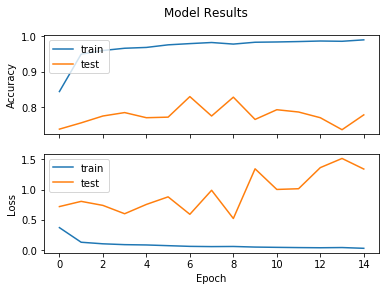

In [19]:
visualize_training_results(dropout_20_history)

In [20]:
dp20 = load_model('best_dropout_20.h5')
model_evaluation(dp20)

163/163 [==============================] - 11s 66ms/step - loss: 0.0766 - accuracy: 0.9712
Training Loss:0.07663
Training Accuracy:0.9712
1/1 [==============================] - 0s 129ms/step - loss: 0.0855 - accuracy: 1.0000
Val Loss:0.08555
Val Accuracy:1.0


>**Comment:** Dropout 20%
- The dropout_20 model took less time to run compare with the baseline model
- The train accuracy (0.9712) is lower than val accuracy (1.0) which indicates the model is slightly underfit
- Using a dropout layer decrease the complexity of the model thus cause underfitting

#### Dropout 20b

In [11]:
dropout_20b = models.Sequential()
dropout_20b.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
dropout_20b.add(layers.MaxPooling2D((2, 2)))
dropout_20b.add(layers.Dropout(0.2))

dropout_20b.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_20b.add(layers.MaxPooling2D((2, 2)))
dropout_20b.add(layers.Dropout(0.2))

dropout_20b.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_20b.add(layers.MaxPooling2D((2, 2)))
dropout_20b.add(layers.Dropout(0.2))

dropout_20b.add(layers.Flatten())
dropout_20b.add(layers.Dense(128, activation='relu'))
dropout_20b.add(layers.Dropout(0.2))
dropout_20b.add(layers.Dense(1, activation='sigmoid'))

dropout_20b.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [12]:
es_dp_20b = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
            ModelCheckpoint(filepath='best_dropout_20b.h5', 
                            monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]  

In [13]:
dropout_20b_history = dropout_20b.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_dp_20b,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 48s 293ms/step - loss: 0.5207 - accuracy: 0.7878 - val_loss: 0.7091 - val_accuracy: 0.7260

Epoch 00001: val_accuracy improved from -inf to 0.72596, saving model to best_dropout_20b.h5
Epoch 2/50
163/163 [==============================] - 47s 287ms/step - loss: 0.1186 - accuracy: 0.9572 - val_loss: 0.5289 - val_accuracy: 0.7885

Epoch 00002: val_accuracy improved from 0.72596 to 0.78846, saving model to best_dropout_20b.h5
Epoch 3/50
163/163 [==============================] - 47s 288ms/step - loss: 0.1032 - accuracy: 0.9669 - val_loss: 0.7739 - val_accuracy: 0.7404

Epoch 00003: val_accuracy did not improve from 0.78846
Epoch 4/50
163/163 [==============================] - 47s 287ms/step - loss: 0.0949 - accuracy: 0.9670 - val_loss: 0.7697 - val_accuracy: 0.7804

Epoch 00004: val_accuracy did not improve from 0.78846
Epoch 5/50
163/163 [==============================] - 47s 287ms/step - loss: 0.0672 - accuracy: 0.9758 - val_loss: 0.

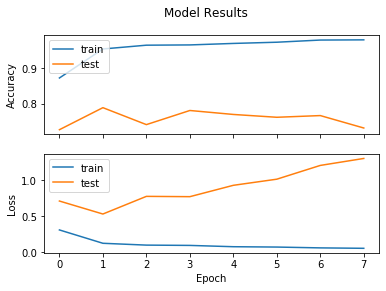

In [14]:
visualize_training_results(dropout_20b_history)

In [15]:
dp20b = load_model('best_dropout_20b.h5')
model_evaluation(dp20b)

163/163 [==============================] - 11s 66ms/step - loss: 0.1055 - accuracy: 0.9680
Training Loss:0.1055
Training Accuracy:0.968
1/1 [==============================] - 0s 130ms/step - loss: 0.3069 - accuracy: 0.8125
Val Loss:0.3069
Val Accuracy:0.8125


#### Dropout 50
- Add (50%) dropout layer and earlystopping

In [21]:
dropout_50 = models.Sequential()
dropout_50.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)))
dropout_50.add(layers.MaxPooling2D((2, 2)))
dropout_50.add(layers.Dropout(0.5))

dropout_50.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_50.add(layers.MaxPooling2D((2, 2)))
dropout_50.add(layers.Dropout(0.5))

dropout_50.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_50.add(layers.MaxPooling2D((2, 2)))
dropout_50.add(layers.Dropout(0.5))

dropout_50.add(layers.Flatten())
dropout_50.add(layers.Dense(128, activation='relu'))
dropout_50.add(layers.Dense(1, activation='sigmoid'))

dropout_50.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [22]:
es_dp_50 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
            ModelCheckpoint(filepath='best_dropout_50.h5', monitor='val_accuracy', 
                            mode='max', verbose=1, save_best_only=True)]

In [23]:
dropout_50_history = dropout_50.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_dp_50,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 49s 295ms/step - loss: 0.6889 - accuracy: 0.7211 - val_loss: 0.4302 - val_accuracy: 0.8077

Epoch 00001: val_accuracy improved from -inf to 0.80769, saving model to best_dropout_50.h5
Epoch 2/50
163/163 [==============================] - 47s 290ms/step - loss: 0.2108 - accuracy: 0.9120 - val_loss: 0.6183 - val_accuracy: 0.7484

Epoch 00002: val_accuracy did not improve from 0.80769
Epoch 3/50
163/163 [==============================] - 48s 292ms/step - loss: 0.1517 - accuracy: 0.9385 - val_loss: 0.5473 - val_accuracy: 0.7740

Epoch 00003: val_accuracy did not improve from 0.80769
Epoch 4/50
163/163 [==============================] - 48s 297ms/step - loss: 0.1238 - accuracy: 0.9581 - val_loss: 0.7113 - val_accuracy: 0.7163

Epoch 00004: val_accuracy did not improve from 0.80769
Epoch 5/50
163/163 [==============================] - 50s 306ms/step - loss: 0.1278 - accuracy: 0.9532 - val_loss: 0.5873 - val_accuracy: 0.7484

Epoch 00005: 

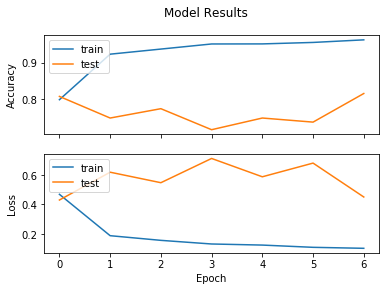

In [24]:
visualize_training_results(dropout_50_history)

In [25]:
dp50 = load_model('best_dropout_50.h5')
model_evaluation(dp50)

163/163 [==============================] - 11s 70ms/step - loss: 0.1172 - accuracy: 0.9689
Training Loss:0.1172
Training Accuracy:0.9689
1/1 [==============================] - 0s 131ms/step - loss: 0.2597 - accuracy: 1.0000
Val Loss:0.2597
Val Accuracy:1.0


### L2 Regularizer

In [11]:
L2_reg = models.Sequential()
L2_reg.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu', input_shape=(128,128,3)))
L2_reg.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu'))
L2_reg.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.005), activation='relu'))
L2_reg.add(layers.MaxPooling2D((2, 2)))

L2_reg.add(layers.Flatten())
L2_reg.add(layers.Dense(128, activation='relu'))
L2_reg.add(layers.Dense(1, activation='sigmoid'))

L2_reg.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [12]:
es_L2 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
         ModelCheckpoint(filepath='best_L2.h5', 
                         monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [13]:
L2_reg_history = L2_reg.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            callbacks=es_L2,
                            validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 43s 263ms/step - loss: 0.8190 - accuracy: 0.7902 - val_loss: 0.7795 - val_accuracy: 0.7724

Epoch 00001: val_accuracy improved from -inf to 0.77244, saving model to best_L2.h5
Epoch 2/50
163/163 [==============================] - 43s 261ms/step - loss: 0.2205 - accuracy: 0.9598 - val_loss: 0.6571 - val_accuracy: 0.7837

Epoch 00002: val_accuracy improved from 0.77244 to 0.78365, saving model to best_L2.h5
Epoch 3/50
163/163 [==============================] - 43s 262ms/step - loss: 0.1693 - accuracy: 0.9684 - val_loss: 0.8769 - val_accuracy: 0.7676

Epoch 00003: val_accuracy did not improve from 0.78365
Epoch 4/50
163/163 [==============================] - 43s 264ms/step - loss: 0.1539 - accuracy: 0.9647 - val_loss: 0.7050 - val_accuracy: 0.7853

Epoch 00004: val_accuracy improved from 0.78365 to 0.78526, saving model to best_L2.h5
Epoch 5/50
163/163 [==============================] - 43s 264ms/step - loss: 0.1283 - accuracy: 0.9707 

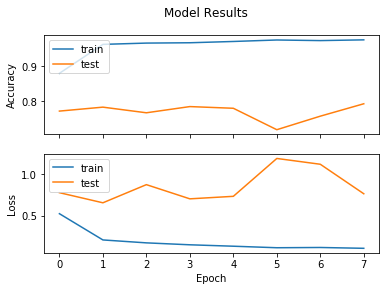

In [14]:
visualize_training_results(L2_reg_history)

In [15]:
L2 = load_model('best_L2.h5')
model_evaluation(L2)

163/163 [==============================] - 11s 68ms/step - loss: 0.0959 - accuracy: 0.9808
Training Loss:0.0959
Training Accuracy:0.9808
1/1 [==============================] - 0s 145ms/step - loss: 0.3370 - accuracy: 0.8125
Val Loss:0.337
Val Accuracy:0.8125


>**Comment:** 
- The L2 model took less time to run compare with the baseline model
- The train accuracy (0.9808) is higher than val accuracy (0.8126) which indicates the mode is overfit
- Using a L2 regularizer can not effectively improve the model performance

#### L2_01

In [16]:
L2_01 = models.Sequential()
L2_01.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(128,128,3)))
L2_01.add(layers.MaxPooling2D((2, 2)))

L2_01.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
L2_01.add(layers.MaxPooling2D((2, 2)))

L2_01.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
L2_01.add(layers.MaxPooling2D((2, 2)))

L2_01.add(layers.Flatten())
L2_01.add(layers.Dense(128, activation='relu'))
L2_01.add(layers.Dense(1, activation='sigmoid'))

L2_01.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [17]:
es_L2_01 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
                    ModelCheckpoint(filepath='best_L2_01.h5', 
                                    monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [18]:
L2_01_history = L2_01.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_L2_01,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 43s 261ms/step - loss: 1.1511 - accuracy: 0.7802 - val_loss: 0.8041 - val_accuracy: 0.7612

Epoch 00001: val_accuracy improved from -inf to 0.76122, saving model to best_L2_01.h5
Epoch 2/50
163/163 [==============================] - 43s 266ms/step - loss: 0.2782 - accuracy: 0.9547 - val_loss: 0.6924 - val_accuracy: 0.7692

Epoch 00002: val_accuracy improved from 0.76122 to 0.76923, saving model to best_L2_01.h5
Epoch 3/50
163/163 [==============================] - 43s 263ms/step - loss: 0.2047 - accuracy: 0.9644 - val_loss: 0.7289 - val_accuracy: 0.7885

Epoch 00003: val_accuracy improved from 0.76923 to 0.78846, saving model to best_L2_01.h5
Epoch 4/50
163/163 [==============================] - 46s 280ms/step - loss: 0.1814 - accuracy: 0.9639 - val_loss: 0.7634 - val_accuracy: 0.7628

Epoch 00004: val_accuracy did not improve from 0.78846
Epoch 5/50
163/163 [==============================] - 46s 284ms/step - loss: 0.1462 - accuracy

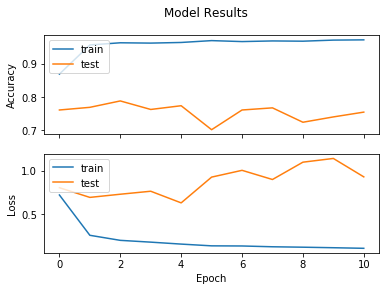

In [19]:
visualize_training_results(L2_01_history)

In [20]:
L201 = load_model('best_L2_01.h5')
model_evaluation(L201)

163/163 [==============================] - 11s 70ms/step - loss: 0.1782 - accuracy: 0.9615
Training Loss:0.1782
Training Accuracy:0.9615
1/1 [==============================] - 0s 142ms/step - loss: 0.2084 - accuracy: 1.0000
Val Loss:0.2084
Val Accuracy:1.0


### L1 Regularizer

In [21]:
L1_reg = models.Sequential()
L1_reg.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1(0.005), activation='relu', input_shape=(128,128,3)))
L1_reg.add(layers.MaxPooling2D((2, 2)))

L1_reg.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
L1_reg.add(layers.MaxPooling2D((2, 2)))

L1_reg.add(layers.Conv2D(128, (3, 3), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
L1_reg.add(layers.MaxPooling2D((2, 2)))

L1_reg.add(layers.Flatten())
L1_reg.add(layers.Dense(128, activation='relu'))
L1_reg.add(layers.Dense(1, activation='sigmoid'))

L1_reg.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [22]:
es_L1 = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
         ModelCheckpoint(filepath='best_L1.h5', monitor='val_accuracy', 
                         mode='max', verbose=1, save_best_only=True)]

In [23]:
L1_reg_history = L1_reg.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            callbacks=es_L1,
                            validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 43s 263ms/step - loss: 6.7566 - accuracy: 0.7530 - val_loss: 0.6154 - val_accuracy: 0.8317

Epoch 00001: val_accuracy improved from -inf to 0.83173, saving model to best_L1.h5
Epoch 2/50
163/163 [==============================] - 42s 260ms/step - loss: 0.3986 - accuracy: 0.9262 - val_loss: 0.8050 - val_accuracy: 0.7500

Epoch 00002: val_accuracy did not improve from 0.83173
Epoch 3/50
163/163 [==============================] - 43s 263ms/step - loss: 0.2983 - accuracy: 0.9464 - val_loss: 0.7473 - val_accuracy: 0.7740

Epoch 00003: val_accuracy did not improve from 0.83173
Epoch 4/50
163/163 [==============================] - 43s 263ms/step - loss: 0.2671 - accuracy: 0.9529 - val_loss: 0.6348 - val_accuracy: 0.7965

Epoch 00004: val_accuracy did not improve from 0.83173
Epoch 5/50
163/163 [==============================] - 43s 264ms/step - loss: 0.2381 - accuracy: 0.9552 - val_loss: 0.7924 - val_accuracy: 0.7532

Epoch 00005: val_accu

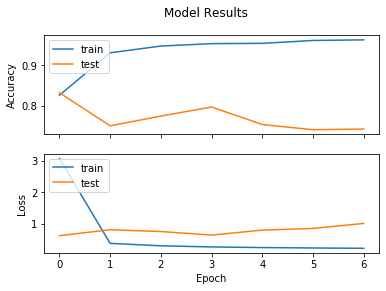

In [24]:
visualize_training_results(L1_reg_history)

In [25]:
L1 = load_model('best_L1.h5')
model_evaluation(L1)

163/163 [==============================] - 12s 71ms/step - loss: 0.4379 - accuracy: 0.9294
Training Loss:0.4379
Training Accuracy:0.9294
1/1 [==============================] - 0s 137ms/step - loss: 0.7701 - accuracy: 0.8125
Val Loss:0.7701
Val Accuracy:0.8125


### Valid

In [97]:
valid = models.Sequential()
valid.add(layers.Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(128,128,3)))
valid.add(layers.MaxPooling2D((2, 2)))

valid.add(layers.Conv2D(64, (3, 3), padding='valid', activation='relu'))
valid.add(layers.MaxPooling2D((2, 2)))

valid.add(layers.Conv2D(128, (3, 3), padding='valid', activation='relu'))
valid.add(layers.MaxPooling2D((2, 2)))

valid.add(layers.Flatten())
valid.add(layers.Dense(128, activation='relu'))
valid.add(layers.Dense(1, activation='sigmoid'))

valid.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [98]:
es_valid = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
                 ModelCheckpoint(filepath='best_valid.h5', 
                                 monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [99]:
valid_history = valid.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_valid,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 44s 268ms/step - loss: 0.3881 - accuracy: 0.8227 - val_loss: 0.9831 - val_accuracy: 0.7532

Epoch 00001: val_accuracy improved from -inf to 0.75321, saving model to best_valid.h5
Epoch 2/50
163/163 [==============================] - 42s 260ms/step - loss: 0.1141 - accuracy: 0.9606 - val_loss: 1.0409 - val_accuracy: 0.7612

Epoch 00002: val_accuracy improved from 0.75321 to 0.76122, saving model to best_valid.h5
Epoch 3/50
163/163 [==============================] - 43s 261ms/step - loss: 0.0700 - accuracy: 0.9748 - val_loss: 1.5113 - val_accuracy: 0.7083

Epoch 00003: val_accuracy did not improve from 0.76122
Epoch 4/50
163/163 [==============================] - 42s 260ms/step - loss: 0.0536 - accuracy: 0.9818 - val_loss: 0.8939 - val_accuracy: 0.8077

Epoch 00004: val_accuracy improved from 0.76122 to 0.80769, saving model to best_valid.h5
Epoch 5/50
163/163 [==============================] - 42s 260ms/step - loss: 0.0498 - accuracy

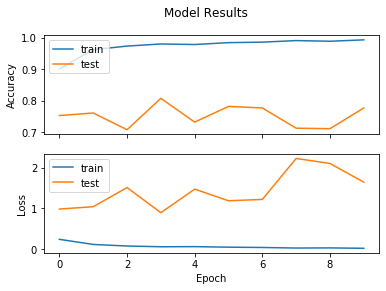

In [100]:
visualize_training_results(valid_history)

In [101]:
validd = load_model('best_valid.h5')
model_evaluation(validd)

163/163 [==============================] - 11s 65ms/step - loss: 0.0673 - accuracy: 0.9720
Training Loss:0.06727
Training Accuracy:0.972
1/1 [==============================] - 0s 129ms/step - loss: 0.0677 - accuracy: 1.0000
Val Loss:0.06771
Val Accuracy:1.0


### Padding

In [31]:
padding = models.Sequential()
padding.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128,128,3)))
padding.add(layers.MaxPooling2D((2, 2)))

padding.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
padding.add(layers.MaxPooling2D((2, 2)))

padding.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
padding.add(layers.MaxPooling2D((2, 2)))

padding.add(layers.Flatten())
padding.add(layers.Dense(128, activation='relu'))
padding.add(layers.Dense(1, activation='sigmoid'))

padding.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [32]:
es_padding = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
                 ModelCheckpoint(filepath='best_padding.h5', 
                                 monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [33]:
padding_history = padding.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_padding,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 49s 299ms/step - loss: 0.4414 - accuracy: 0.8206 - val_loss: 1.0212 - val_accuracy: 0.7404

Epoch 00001: val_accuracy improved from -inf to 0.74038, saving model to best_padding.h5
Epoch 2/50
163/163 [==============================] - 46s 283ms/step - loss: 0.1033 - accuracy: 0.9642 - val_loss: 1.4050 - val_accuracy: 0.7276

Epoch 00002: val_accuracy did not improve from 0.74038
Epoch 3/50
163/163 [==============================] - 47s 289ms/step - loss: 0.0756 - accuracy: 0.9733 - val_loss: 1.4857 - val_accuracy: 0.6955

Epoch 00003: val_accuracy did not improve from 0.74038
Epoch 4/50
163/163 [==============================] - 50s 306ms/step - loss: 0.0620 - accuracy: 0.9753 - val_loss: 1.0816 - val_accuracy: 0.7660

Epoch 00004: val_accuracy improved from 0.74038 to 0.76603, saving model to best_padding.h5
Epoch 5/50
163/163 [==============================] - 48s 296ms/step - loss: 0.0401 - accuracy: 0.9863 - val_loss: 1.4899 - v

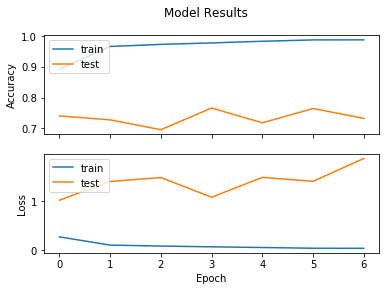

In [34]:
visualize_training_results(padding_history)

In [35]:
pad = load_model('best_padding.h5')
model_evaluation(pad)

163/163 [==============================] - 11s 68ms/step - loss: 0.0355 - accuracy: 0.9868
Training Loss:0.03547
Training Accuracy:0.9868
1/1 [==============================] - 0s 138ms/step - loss: 0.2367 - accuracy: 0.9375
Val Loss:0.2367
Val Accuracy:0.9375


#### best_padding prediction TRY

In [87]:
pad.predict(X_val)

array([[0.9871],
       [0.9939],
       [0.1664],
       [0.0005],
       [0.    ],
       [0.053 ],
       [0.5939],
       [0.    ],
       [0.8715],
       [0.9982],
       [0.9687],
       [0.    ],
       [0.0682],
       [0.8899],
       [0.0009],
       [0.0346]], dtype=float32)

In [94]:
# predict_proba was deprecated
prob = pad.predict(X_val).flatten()
prob

array([0.9871, 0.9939, 0.1664, 0.0005, 0.    , 0.053 , 0.5939, 0.    ,
       0.8715, 0.9982, 0.9687, 0.    , 0.0682, 0.8899, 0.0009, 0.0346],
      dtype=float32)

In [89]:
# pad.predict_classes(X_val) was deprecated
pred_val = ((pad.predict(X_val) > 0.5).astype("int32")).flatten()
pred_val

array([1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0], dtype=int32)

In [90]:
act_val = y_val.astype("int32").flatten()
act_val

array([1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0], dtype=int32)

In [95]:
padding_actual_pred = pd.concat([pd.Series(act_val, name="Actual"),
                                 pd.Series(pred_val, name="Predicted"),
                                 pd.Series(prob, name="Probabilities")], axis=1)

In [96]:
padding_actual_pred

,Actual,Predicted,Probabilities
0,1,1,9.871247e-01
1,1,1,9.939204e-01
2,0,0,1.663717e-01
3,0,0,4.838109e-04
4,0,0,2.925011e-06
5,0,0,5.295247e-02
6,1,1,5.939111e-01
7,0,0,2.594457e-05
8,1,1,8.714564e-01
9,1,1,9.981869e-01


## he_init

In [59]:
he_init = models.Sequential()
he_init.add(layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', input_shape=(128,128,3)))
he_init.add(layers.MaxPooling2D((2, 2)))

he_init.add(layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu'))
he_init.add(layers.MaxPooling2D((2, 2)))

he_init.add(layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', activation='relu'))
he_init.add(layers.MaxPooling2D((2, 2)))

he_init.add(layers.Flatten())
he_init.add(layers.Dense(128, activation='relu'))
he_init.add(layers.Dense(1, activation='sigmoid'))

he_init.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [60]:
es_he = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
                    ModelCheckpoint(filepath='best_he.h5', monitor='val_accuracy', 
                                    mode='max', verbose=1, save_best_only=True)]

In [61]:
he_init_history = he_init.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_he,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 45s 276ms/step - loss: 0.4984 - accuracy: 0.8660 - val_loss: 1.2603 - val_accuracy: 0.7308

Epoch 00001: val_accuracy improved from -inf to 0.73077, saving model to best_he.h5
Epoch 2/50
163/163 [==============================] - 40s 245ms/step - loss: 0.0955 - accuracy: 0.9656 - val_loss: 0.8698 - val_accuracy: 0.7804

Epoch 00002: val_accuracy improved from 0.73077 to 0.78045, saving model to best_he.h5
Epoch 3/50
163/163 [==============================] - 40s 248ms/step - loss: 0.0581 - accuracy: 0.9780 - val_loss: 1.4375 - val_accuracy: 0.7244

Epoch 00003: val_accuracy did not improve from 0.78045
Epoch 4/50
163/163 [==============================] - 41s 251ms/step - loss: 0.0433 - accuracy: 0.9833 - val_loss: 1.2736 - val_accuracy: 0.7740

Epoch 00004: val_accuracy did not improve from 0.78045
Epoch 5/50
163/163 [==============================] - 41s 250ms/step - loss: 0.0388 - accuracy: 0.9862 - val_loss: 1.4030 - val_accurac

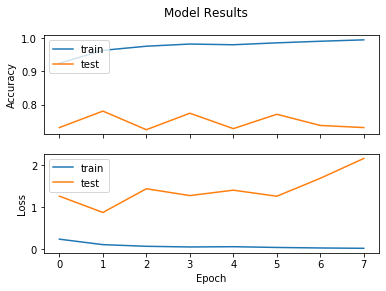

In [62]:
visualize_training_results(he_init_history)

In [63]:
he = load_model('best_he.h5')
model_evaluation(he)

163/163 [==============================] - 10s 63ms/step - loss: 0.0581 - accuracy: 0.9781
Training Loss:0.05812
Training Accuracy:0.9781
1/1 [==============================] - 0s 135ms/step - loss: 0.3599 - accuracy: 0.8125
Val Loss:0.3599
Val Accuracy:0.8125


## Lecun_init

In [68]:
lecun_init = models.Sequential()
lecun_init.add(layers.Conv2D(32, (3, 3), kernel_initializer='lecun_normal', activation='relu', input_shape=(128,128,3)))
lecun_init.add(layers.MaxPooling2D((2, 2)))

lecun_init.add(layers.Conv2D(64, (3, 3), kernel_initializer='lecun_normal', activation='relu'))
lecun_init.add(layers.MaxPooling2D((2, 2)))

lecun_init.add(layers.Conv2D(128, (3, 3), kernel_initializer='lecun_normal', activation='relu'))
lecun_init.add(layers.MaxPooling2D((2, 2)))

lecun_init.add(layers.Flatten())
lecun_init.add(layers.Dense(128, activation='relu'))
lecun_init.add(layers.Dense(1, activation='sigmoid'))

lecun_init.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [69]:
es_lecun = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6),
                    ModelCheckpoint(filepath='best_lecun.h5', monitor='val_accuracy', 
                                    mode='max', verbose=1, save_best_only=True)]

In [70]:
lecun_init_history = lecun_init.fit(X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=es_lecun,
                                validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 45s 273ms/step - loss: 0.5458 - accuracy: 0.8256 - val_loss: 0.5165 - val_accuracy: 0.7965

Epoch 00001: val_accuracy improved from -inf to 0.79647, saving model to best_lecun.h5
Epoch 2/50
163/163 [==============================] - 46s 280ms/step - loss: 0.1056 - accuracy: 0.9610 - val_loss: 0.6939 - val_accuracy: 0.7917

Epoch 00002: val_accuracy did not improve from 0.79647
Epoch 3/50
163/163 [==============================] - 42s 257ms/step - loss: 0.0740 - accuracy: 0.9693 - val_loss: 1.2661 - val_accuracy: 0.7676

Epoch 00003: val_accuracy did not improve from 0.79647
Epoch 4/50
163/163 [==============================] - 42s 255ms/step - loss: 0.0688 - accuracy: 0.9727 - val_loss: 0.9297 - val_accuracy: 0.7276

Epoch 00004: val_accuracy did not improve from 0.79647
Epoch 5/50
163/163 [==============================] - 42s 256ms/step - loss: 0.0737 - accuracy: 0.9747 - val_loss: 0.8173 - val_accuracy: 0.8077

Epoch 00005: val_a

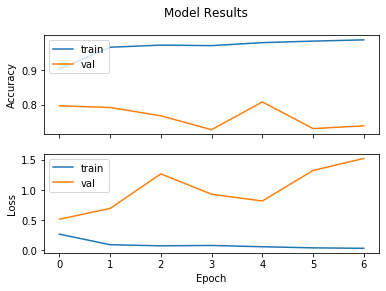

In [71]:
visualize_training_results(lecun_init_history)

In [72]:
lecun = load_model('best_lecun.h5')
model_evaluation(lecun)

163/163 [==============================] - 11s 65ms/step - loss: 0.0518 - accuracy: 0.9812
[0.05178162455558777, 0.9812116622924805]
1/1 [==============================] - 0s 129ms/step - loss: 0.1005 - accuracy: 0.9375
[0.10053324699401855, 0.9375]
